**Clone the github repository**

In [1]:
!rm -rf /kaggle/working/mae
!git clone https://github.com/facebookresearch/mae.git

Cloning into 'mae'...
remote: Enumerating objects: 39, done.
remote: Total 39 (delta 0), reused 0 (delta 0), pack-reused 39 (from 1)
Receiving objects: 100% (39/39), 834.95 KiB | 5.22 MiB/s, done.
Resolving deltas: 100% (9/9), done.


In [2]:
ls

__notebook__.ipynb  mae/


In [3]:
cd mae

/kaggle/working/mae


**Installing modules**

In [4]:
!pip install transformers datasets torch torchvision torchsummary -q

**Updating the model architecture**

In [5]:
%%writefile "models_mae.py"
# %load "models_mae"
# Copyright (c) Meta Platforms, Inc. and affiliates.
# All rights reserved.

# This source code is licensed under the license found in the
# LICENSE file in the root directory of this source tree.
# --------------------------------------------------------
# References:
# timm: https://github.com/rwightman/pytorch-image-models/tree/master/timm
# DeiT: https://github.com/facebookresearch/deit
# --------------------------------------------------------
from functools import partial

import torch
import torch.nn as nn

from timm.models.vision_transformer import PatchEmbed, Block

from util.pos_embed import get_2d_sincos_pos_embed


class MaskedAutoencoderViT(nn.Module):
    """ Masked Autoencoder with VisionTransformer backbone
    """
    def __init__(self, img_size=224, patch_size=16, in_chans=3,
                 embed_dim=1024, depth=24, num_heads=16,
                 decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16,
                 mlp_ratio=4., norm_layer=nn.LayerNorm, norm_pix_loss=False):
        super().__init__()

        # --------------------------------------------------------------------------
        # MAE encoder specifics
        self.patch_embed = PatchEmbed(img_size, patch_size, in_chans, embed_dim)
        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim), requires_grad=False)  # fixed sin-cos embedding

        self.blocks = nn.ModuleList([
            Block(embed_dim, num_heads, mlp_ratio, qkv_bias=True, norm_layer=norm_layer)
            for i in range(depth)])
        self.norm = norm_layer(embed_dim)
        # --------------------------------------------------------------------------

        # --------------------------------------------------------------------------
        # MAE decoder specifics
        self.decoder_embed = nn.Linear(embed_dim, decoder_embed_dim, bias=True)

        self.mask_token = nn.Parameter(torch.zeros(1, 1, decoder_embed_dim))

        self.decoder_pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, decoder_embed_dim), requires_grad=False)  # fixed sin-cos embedding

        self.decoder_blocks = nn.ModuleList([
            Block(decoder_embed_dim, decoder_num_heads, mlp_ratio, qkv_bias=True, norm_layer=norm_layer)
            for i in range(decoder_depth)])

        self.decoder_norm = norm_layer(decoder_embed_dim)
        self.decoder_pred = nn.Linear(decoder_embed_dim, patch_size**2 * in_chans, bias=True) # decoder to patch
        # --------------------------------------------------------------------------

        self.norm_pix_loss = norm_pix_loss

        self.initialize_weights()

    def initialize_weights(self):
        # initialization
        # initialize (and freeze) pos_embed by sin-cos embedding
        pos_embed = get_2d_sincos_pos_embed(self.pos_embed.shape[-1], int(self.patch_embed.num_patches**.5), cls_token=True)
        self.pos_embed.data.copy_(torch.from_numpy(pos_embed).float().unsqueeze(0))

        decoder_pos_embed = get_2d_sincos_pos_embed(self.decoder_pos_embed.shape[-1], int(self.patch_embed.num_patches**.5), cls_token=True)
        self.decoder_pos_embed.data.copy_(torch.from_numpy(decoder_pos_embed).float().unsqueeze(0))

        # initialize patch_embed like nn.Linear (instead of nn.Conv2d)
        w = self.patch_embed.proj.weight.data
        torch.nn.init.xavier_uniform_(w.view([w.shape[0], -1]))

        # timm's trunc_normal_(std=.02) is effectively normal_(std=0.02) as cutoff is too big (2.)
        torch.nn.init.normal_(self.cls_token, std=.02)
        torch.nn.init.normal_(self.mask_token, std=.02)

        # initialize nn.Linear and nn.LayerNorm
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            # we use xavier_uniform following official JAX ViT:
            torch.nn.init.xavier_uniform_(m.weight)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def patchify(self, imgs):
        """
        imgs: (N, 3, H, W)
        x: (N, L, patch_size**2 *3)
        """
        p = self.patch_embed.patch_size[0]
        assert imgs.shape[2] == imgs.shape[3] and imgs.shape[2] % p == 0

        h = w = imgs.shape[2] // p
        x = imgs.reshape(shape=(imgs.shape[0], 3, h, p, w, p))
        x = torch.einsum('nchpwq->nhwpqc', x)
        x = x.reshape(shape=(imgs.shape[0], h * w, p**2 * 3))
        return x

    def unpatchify(self, x):
        """
        x: (N, L, patch_size**2 *3)
        imgs: (N, 3, H, W)
        """
        p = self.patch_embed.patch_size[0]
        h = w = int(x.shape[1]**.5)
        assert h * w == x.shape[1]
        
        x = x.reshape(shape=(x.shape[0], h, w, p, p, 3))
        x = torch.einsum('nhwpqc->nchpwq', x)
        imgs = x.reshape(shape=(x.shape[0], 3, h * p, h * p))
        return imgs

    def random_masking(self, x, mask_ratio):
        """
        Perform per-sample random masking by per-sample shuffling.
        Per-sample shuffling is done by argsort random noise.
        x: [N, L, D], sequence
        """
        N, L, D = x.shape  # batch, length, dim
        len_keep = int(L * (1 - mask_ratio))
        
        noise = torch.rand(N, L, device=x.device)  # noise in [0, 1]
        
        # sort noise for each sample
        ids_shuffle = torch.argsort(noise, dim=1)  # ascend: small is keep, large is remove
        ids_restore = torch.argsort(ids_shuffle, dim=1)

        # keep the first subset
        ids_keep = ids_shuffle[:, :len_keep]
        x_masked = torch.gather(x, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, D))

        # generate the binary mask: 0 is keep, 1 is remove
        mask = torch.ones([N, L], device=x.device)
        mask[:, :len_keep] = 0
        # unshuffle to get the binary mask
        mask = torch.gather(mask, dim=1, index=ids_restore)

        return x_masked, mask, ids_restore

    def forward_encoder(self, x, mask_ratio):
        # embed patches
        x = self.patch_embed(x)

        # add pos embed w/o cls token
        x = x + self.pos_embed[:, 1:, :]

        # masking: length -> length * mask_ratio
        x, mask, ids_restore = self.random_masking(x, mask_ratio)

        # append cls token
        cls_token = self.cls_token + self.pos_embed[:, :1, :]
        cls_tokens = cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)

        # apply Transformer blocks
        for blk in self.blocks:
            x = blk(x)
        x = self.norm(x)

        return x, mask, ids_restore

    def forward_decoder(self, x, ids_restore):
        # embed tokens
        x = self.decoder_embed(x)

        # append mask tokens to sequence
        mask_tokens = self.mask_token.repeat(x.shape[0], ids_restore.shape[1] + 1 - x.shape[1], 1)
        x_ = torch.cat([x[:, 1:, :], mask_tokens], dim=1)  # no cls token
        x_ = torch.gather(x_, dim=1, index=ids_restore.unsqueeze(-1).repeat(1, 1, x.shape[2]))  # unshuffle
        x = torch.cat([x[:, :1, :], x_], dim=1)  # append cls token

        # add pos embed
        x = x + self.decoder_pos_embed

        # apply Transformer blocks
        for blk in self.decoder_blocks:
            x = blk(x)
        x = self.decoder_norm(x)

        # predictor projection
        x = self.decoder_pred(x)

        # remove cls token
        x = x[:, 1:, :]

        return x

    def forward_loss(self, imgs, pred, mask):
        """
        imgs: [N, 3, H, W]
        pred: [N, L, p*p*3]
        mask: [N, L], 0 is keep, 1 is remove, 
        """
        target = self.patchify(imgs)
        if self.norm_pix_loss:
            mean = target.mean(dim=-1, keepdim=True)
            var = target.var(dim=-1, keepdim=True)
            target = (target - mean) / (var + 1.e-6)**.5

        loss = (pred - target) ** 2
        loss = loss.mean(dim=-1)  # [N, L], mean loss per patch

        loss = (loss * mask).sum() / mask.sum()  # mean loss on removed patches
        return loss

    def forward(self, imgs, mask_ratio=0.75):
        latent, mask, ids_restore = self.forward_encoder(imgs, mask_ratio)
        pred = self.forward_decoder(latent, ids_restore)  # [N, L, p*p*3]
        loss = self.forward_loss(imgs, pred, mask)
        return loss, pred, mask


def mae_vit_base_patch16_dec512d8b(**kwargs):
    model = MaskedAutoencoderViT(
        patch_size=16, embed_dim=768, depth=12, num_heads=12,
        decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16,
        mlp_ratio=4, norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    return model


def mae_vit_large_patch16_dec512d8b(**kwargs):
    model = MaskedAutoencoderViT(
        patch_size=16, embed_dim=1024, depth=24, num_heads=16,
        decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16,
        mlp_ratio=4, norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    return model


def mae_vit_huge_patch14_dec512d8b(**kwargs):
    model = MaskedAutoencoderViT(
        patch_size=14, embed_dim=1280, depth=32, num_heads=16,
        decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16,
        mlp_ratio=4, norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    return model


# set recommended archs
mae_vit_base_patch16 = mae_vit_base_patch16_dec512d8b  # decoder: 512 dim, 8 blocks
mae_vit_large_patch16 = mae_vit_large_patch16_dec512d8b  # decoder: 512 dim, 8 blocks
mae_vit_huge_patch14 = mae_vit_huge_patch14_dec512d8b  # decoder: 512 dim, 8 blocks


Overwriting models_mae.py


**Updating the embedding code**

Conflict due to numpy version change

In [6]:
%%writefile "util/pos_embed.py"
# %load "util/pos_embed.py"
# Copyright (c) Meta Platforms, Inc. and affiliates.
# All rights reserved.

# This source code is licensed under the license found in the
# LICENSE file in the root directory of this source tree.
# --------------------------------------------------------
# Position embedding utils
# --------------------------------------------------------

import numpy as np

import torch

# --------------------------------------------------------
# 2D sine-cosine position embedding
# References:
# Transformer: https://github.com/tensorflow/models/blob/master/official/nlp/transformer/model_utils.py
# MoCo v3: https://github.com/facebookresearch/moco-v3
# --------------------------------------------------------
def get_2d_sincos_pos_embed(embed_dim, grid_size, cls_token=False):
    """
    grid_size: int of the grid height and width
    return:
    pos_embed: [grid_size*grid_size, embed_dim] or [1+grid_size*grid_size, embed_dim] (w/ or w/o cls_token)
    """
    grid_h = np.arange(grid_size, dtype=np.float32)
    grid_w = np.arange(grid_size, dtype=np.float32)
    grid = np.meshgrid(grid_w, grid_h)  # here w goes first
    grid = np.stack(grid, axis=0)

    grid = grid.reshape([2, 1, grid_size, grid_size])
    pos_embed = get_2d_sincos_pos_embed_from_grid(embed_dim, grid)
    if cls_token:
        pos_embed = np.concatenate([np.zeros([1, embed_dim]), pos_embed], axis=0)
    return pos_embed


def get_2d_sincos_pos_embed_from_grid(embed_dim, grid):
    assert embed_dim % 2 == 0

    # use half of dimensions to encode grid_h
    emb_h = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[0])  # (H*W, D/2)
    emb_w = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[1])  # (H*W, D/2)

    emb = np.concatenate([emb_h, emb_w], axis=1) # (H*W, D)
    return emb


def get_1d_sincos_pos_embed_from_grid(embed_dim, pos):
    """
    embed_dim: output dimension for each position
    pos: a list of positions to be encoded: size (M,)
    out: (M, D)
    """
    assert embed_dim % 2 == 0
    omega = np.arange(embed_dim // 2, dtype=np.float64)
    omega /= embed_dim / 2.
    omega = 1. / 10000**omega  # (D/2,)

    pos = pos.reshape(-1)  # (M,)
    out = np.einsum('m,d->md', pos, omega)  # (M, D/2), outer product

    emb_sin = np.sin(out) # (M, D/2)
    emb_cos = np.cos(out) # (M, D/2)

    emb = np.concatenate([emb_sin, emb_cos], axis=1)  # (M, D)
    return emb


# --------------------------------------------------------
# Interpolate position embeddings for high-resolution
# References:
# DeiT: https://github.com/facebookresearch/deit
# --------------------------------------------------------
def interpolate_pos_embed(model, checkpoint_model):
    if 'pos_embed' in checkpoint_model:
        pos_embed_checkpoint = checkpoint_model['pos_embed']
        embedding_size = pos_embed_checkpoint.shape[-1]
        num_patches = model.patch_embed.num_patches
        num_extra_tokens = model.pos_embed.shape[-2] - num_patches
        # height (== width) for the checkpoint position embedding
        orig_size = int((pos_embed_checkpoint.shape[-2] - num_extra_tokens) ** 0.5)
        # height (== width) for the new position embedding
        new_size = int(num_patches ** 0.5)
        # class_token and dist_token are kept unchanged
        if orig_size != new_size:
            print("Position interpolate from %dx%d to %dx%d" % (orig_size, orig_size, new_size, new_size))
            extra_tokens = pos_embed_checkpoint[:, :num_extra_tokens]
            # only the position tokens are interpolated
            pos_tokens = pos_embed_checkpoint[:, num_extra_tokens:]
            pos_tokens = pos_tokens.reshape(-1, orig_size, orig_size, embedding_size).permute(0, 3, 1, 2)
            pos_tokens = torch.nn.functional.interpolate(
                pos_tokens, size=(new_size, new_size), mode='bicubic', align_corners=False)
            pos_tokens = pos_tokens.permute(0, 2, 3, 1).flatten(1, 2)
            new_pos_embed = torch.cat((extra_tokens, pos_tokens), dim=1)
            checkpoint_model['pos_embed'] = new_pos_embed


Overwriting util/pos_embed.py


**Unzip the dataset**

In [7]:
# !mkdir -p samples
# !unzip samples.zip -d samples/

**Importing modules**

In [8]:
import os
import time
import seaborn as sns
from matplotlib import pyplot as plt
from PIL import Image
from tqdm import tqdm

import timm
import torch
import torch.nn as nn
from torchsummary import summary
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from torch.optim.lr_scheduler import ReduceLROnPlateau

from transformers import ViTMAEModel
from transformers import AutoImageProcessor, ViTMAEForPreTraining, Trainer, TrainingArguments, ViTImageProcessor, ViTForImageClassification

from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score
import models_mae

**Path to data**

In [9]:
root_path = "/kaggle/input/fire-risk-all-samples/FireRisk"
train_path = root_path + "/train/"
val_path = root_path + "/val"

**Use the checkpoints of firerisk**

In [10]:
def prepare_model(chkpt_dir, arch='mae_vit_base_patch16'):
    # build model
    model = getattr(models_mae, arch)()
    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    #print(checkpoint)
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    return model

**Load the MAE model**

This was trained on Firerisk dataset

In [11]:
# Load the ViTMAE model
#image_processor = ViTImageProcessor.from_pretrained("facebook/vit-mae-base")
vitmae = prepare_model("/kaggle/input/mm/pytorch/default/1/MAE_ImageNet1k.pth")

/tmp/ipykernel_23/2232327184.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(chkpt_dir, map_location='cpu')


**Load the VIT model**

This model was traiend on Eurosat dataset

In [12]:
timm.__version__

'1.0.9'

In [13]:
viteuro = timm.create_model("hf_hub:cm93/vit-base-patch16-224-eurosat", pretrained=True)

config.json:   0%|          | 0.00/829 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

**Freeze the model weights**

In [14]:
# Freeze the ViTMAE model parameters
for param in vitmae.parameters():
    param.requires_grad = False

In [15]:
# Freeze the ViTMAE model parameters
for param in viteuro.parameters():
    param.requires_grad = False

**Dataset Visualization**

In [16]:
# sample_img = Image.open(train_path + "High/27032281_4_-103.430441201095_44.2804260315038.png")
# plt.imshow(sample_img)

**Load dataset**

In [17]:
# 3. Data Transformations
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip images horizontally
    transforms.RandomRotation(15),          # Random rotation within ±15 degrees
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Random crop and resize to 224x224
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Random changes in brightness, contrast, etc.
    transforms.ToTensor(),                  # Convert to tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalize
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),          # Resize to 224x224
    transforms.ToTensor(),                  # Convert to tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalize
])

# 4. Load Dataset using ImageFolder
train_dataset = datasets.ImageFolder(root=train_path, transform=train_transform)
val_dataset = datasets.ImageFolder(root=val_path, transform=val_transform)

# training data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
# validation data loaders
valid_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# 5. Training Setup for Trainer API
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


**Label names**

In [18]:
label_names = train_dataset.classes

**Define the model**

In [19]:
# Define the Custom ViT Model with additional layers
class CustomViTModel(nn.Module):
    def __init__(self, vitmae, viteuro, num_classes=7):
        super(CustomViTModel, self).__init__()

        self.vitmae_embeddings = vitmae.patch_embed
        self.vitmae_encoder = vitmae.blocks

        self.embeddings_eurosat = viteuro.patch_embed
        self.encoder_eurosat = viteuro.blocks

        # LayerNorm for concatenated features
        self.layer_norm = nn.LayerNorm(768 * 2)

        # Additional layers for classification
        self.additional_layers = nn.Sequential(
            nn.LayerNorm(768*2),
            nn.Linear(768*2, 768),
            nn.ReLU(),
            nn.Linear(768, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes),
        )

    def forward(self, pixel_values):
        # Extract embeddings and encoder outputs from ViT-MAE
        vitmae_embeddings = self.vitmae_embeddings(pixel_values)
        for block in self.vitmae_encoder:
            vitmae_embeddings = block(vitmae_embeddings)
        hidden_states_vitmae = vitmae_embeddings[:, 0, :]
        # vit_encoder_outputs = self.vitmae_encoder(vitmae_embeddings)
        # hidden_states_vitmae = vit_encoder_outputs.last_hidden_state[:, 0, :]

        # Extract embeddings and encoder outputs from EuroSAT
        embeddings_eurosat = self.embeddings_eurosat(pixel_values)
        for block in self.encoder_eurosat:
            embeddings_eurosat = block(embeddings_eurosat)
        hidden_states_eurosat = embeddings_eurosat[:, 0, :]

        # Concatenate the hidden states from both models
        fused_features = torch.cat((hidden_states_vitmae, hidden_states_eurosat), dim=1)

        # Apply LayerNorm and pass through additional layers
        fused_features = self.layer_norm(fused_features)
        output = self.additional_layers(fused_features)
        return output

In [20]:
custom_model = CustomViTModel(vitmae, viteuro, num_classes=7)
custom_model = nn.DataParallel(custom_model, device_ids=[0, 1]).to(device)

**Model summary and parameters**

In [21]:
# model summary
print(custom_model)

DataParallel(
  (module): CustomViTModel(
    (vitmae_embeddings): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (vitmae_encoder): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): Identity()
        (drop_path1): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU(approximate='none')
          (drop1): Dropout(p=0.0, inplace=False)
          (norm): Identity()
   

In [22]:
# total parameters and trainable parameters
total_params = sum(p.numel() for p in custom_model.parameters())  #numel returns the number of parameters in the model
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(p.numel() for p in custom_model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

172,873,991 total parameters.
1,583,879 training parameters.


**Training Function**

In [23]:
# training
def train(model, trainloader, optimizer, criterion):
    model.train()
    print('Training')
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0

    all_preds = []
    all_labels = []

    for i, data in tqdm(enumerate(trainloader), total=len(trainloader)):
        counter += 1
        image, labels = data
        image = image.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        # forward pass
        outputs = model(image)
        # calculate the loss
        loss = criterion(outputs, labels)
        train_running_loss += loss.item()
        # calculate the accuracy
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == labels).sum().item()
        # backpropagation
        loss.backward()
        # update the optimizer parameters
        optimizer.step()

    # loss and accuracy for the complete epoch
    epoch_loss = train_running_loss / counter
    epoch_acc = 100. * (train_running_correct / len(trainloader.dataset))

    # Store all predictions and true labels for metrics calculation
    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

    # Calculate precision, recall, and F1-score
    precision = 100.*precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = 100.*recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = 100.*f1_score(all_labels, all_preds, average='weighted', zero_division=0)


    return epoch_loss, epoch_acc, precision, recall, f1

**Validation function**

In [24]:
# validation
def validate(model, testloader, criterion):
    model.eval()
    print('Validation')
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for i, data in tqdm(enumerate(testloader), total=len(testloader)):
            counter += 1

            image, labels = data
            image = image.to(device)
            labels = labels.to(device)
            # forward pass
            outputs = model(image)
            # calculate the loss
            loss = criterion(outputs, labels)
            valid_running_loss += loss.item()
            # calculate the accuracy
            _, preds = torch.max(outputs.data, 1)
            valid_running_correct += (preds == labels).sum().item()

            # Store all predictions and true labels for metrics calculation
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # loss and accuracy for the complete epoch
    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(testloader.dataset))

    # Calculate precision, recall, and F1-score
    precision = 100. * precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = 100. * recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = 100. * f1_score(all_labels, all_preds, average='weighted', zero_division=0)

    return epoch_loss, epoch_acc, precision, recall, f1

**Early stopping**

In [25]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_loss = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0


**Save the model**

In [26]:
def save_model(epochs, model, optimizer, criterion):
    """
    Function to save the trained model to disk.
    """
    # create best model folder
    if not os.path.isdir('outputs'):
        os.mkdir('outputs')

    torch.save({
                'epoch': epochs,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, 'outputs/model.pth')

**Save the plots**

In [27]:
def save_plots(train_acc, valid_acc, train_loss, valid_loss):
    """
    Function to save the loss and accuracy plots to disk.
    """

    # create outputs folder
    if not os.path.isdir('outputs'):
        os.mkdir('outputs')

    # accuracy plots
    plt.figure(figsize=(8, 6))
    plt.plot(
        train_acc, color='green', linestyle='-',
        label='train accuracy'
    )
    plt.plot(
        valid_acc, color='blue', linestyle='-',
        label='validataion accuracy'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig('outputs/accuracy.png')
    plt.show()

    # loss plots
    plt.figure(figsize=(8, 6))
    plt.plot(
        train_loss, color='orange', linestyle='-',
        label='train loss'
    )
    plt.plot(
        valid_loss, color='red', linestyle='-',
        label='validataion loss'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('outputs/loss.png')
    plt.show()

**Save confusion matrix and classifcation report**

In [28]:
def save_confusion_matrix(model, testloader, label_names):
    """
    Function to save the confusion matrix to disk.
    """
    # create outputs folder
    if not os.path.isdir('outputs'):
        os.mkdir('outputs')

    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for i, data in tqdm(enumerate(testloader), total=len(testloader)):
            image, labels = data
            image = image.to(device)
            labels = labels.to(device)
            # forward pass
            outputs = model(image)
            # calculate the accuracy
            _, preds = torch.max(outputs.data, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print("\n\n")
    # Calculate precision, recall, and F1-score
    precision = precision_score(all_labels, all_preds, average='weighted')
    print(f"Precision: {precision}")
    recall = recall_score(all_labels, all_preds, average='weighted')
    print(f"Recall: {recall}")
    f1 = f1_score(all_labels, all_preds, average='weighted')
    print(f"F1-score: {f1}")

    # Display the classification report
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=label_names, zero_division=0))

    print("\Confusion Matrix")
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

**Optimizer and Loss function**

In [29]:
epochs = 30
criterion = nn.CrossEntropyLoss()
optimizer = Adam(custom_model.parameters(), lr=1e-3)
early_stopping = EarlyStopping(patience=7, delta=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=4, factor=0.5, verbose=True)

In [30]:
# lists to keep track of losses and accuracies
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []
# start the training
for epoch in range(epochs):
    print(f"[INFO]: Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_acc, train_precision, train_recall, train_f1 = train(custom_model, train_loader, optimizer, criterion)
    valid_epoch_loss, valid_epoch_acc, valid_precision, valid_recall, valid_f1 = validate(custom_model, valid_loader,  criterion)

    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_acc.append(train_epoch_acc)
    valid_acc.append(valid_epoch_acc)

    print(f"Training loss: {train_epoch_loss:.3f}, Training acc: {train_epoch_acc:.3f},\
      Training precision: {train_precision:.3f}, Training recall: {train_recall:.3f}, Training f1: {train_f1:.3f}")
    print(f"Validation loss: {valid_epoch_loss:.3f}, Validation acc: {valid_epoch_acc:.3f}, \
      Validation precision: {valid_precision:.3f}, Validation recall: {valid_recall:.3f}, Validation f1: {valid_f1:.3f}")
    print('-'*50)
    time.sleep(5)

    # Step the scheduler
    scheduler.step(valid_epoch_loss)

    # Check for early stopping
    early_stopping(valid_epoch_loss)
    if early_stopping.early_stop:
        print("[INFO]: Early stopping triggered.")
        break

    # Save the best model based on validation loss
    if valid_epoch_loss == early_stopping.best_loss:
        save_model(epoch+1, custom_model, optimizer, criterion)


print('TRAINING COMPLETE')

[INFO]: Epoch 1 of 30
Training


  0%|          | 0/1099 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
100%|██████████| 1099/1099 [38:45<00:00,  2.12s/it]


Validation


  0%|          | 0/337 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
100%|██████████| 337/337 [09:26<00:00,  1.68s/it]


Training loss: 1.380, Training acc: 44.973,      Training precision: 54.230, Training recall: 59.322, Training f1: 56.122
Validation loss: 1.252, Validation acc: 51.604,       Validation precision: 50.124, Validation recall: 51.604, Validation f1: 49.615
--------------------------------------------------
[INFO]: Epoch 2 of 30
Training


  0%|          | 0/1099 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
100%|██████████| 1099/1099 [30:40<00:00,  1.67s/it]


Validation


  0%|          | 0/337 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
100%|██████████| 337/337 [07:01<00:00,  1.25s/it]


Training loss: 1.305, Training acc: 47.787,      Training precision: 36.576, Training recall: 49.153, Training f1: 41.859
Validation loss: 1.312, Validation acc: 50.169,       Validation precision: 50.711, Validation recall: 50.169, Validation f1: 47.837
--------------------------------------------------
[INFO]: Epoch 3 of 30
Training


  0%|          | 0/1099 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
100%|██████████| 1099/1099 [30:59<00:00,  1.69s/it]


Validation


  0%|          | 0/337 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
100%|██████████| 337/337 [06:57<00:00,  1.24s/it]


Training loss: 1.277, Training acc: 48.967,      Training precision: 44.070, Training recall: 52.542, Training f1: 47.509
Validation loss: 1.207, Validation acc: 53.507,       Validation precision: 50.721, Validation recall: 53.507, Validation f1: 49.945
--------------------------------------------------
[INFO]: Epoch 4 of 30
Training


  0%|          | 0/1099 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
100%|██████████| 1099/1099 [30:52<00:00,  1.69s/it]


Validation


  0%|          | 0/337 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
100%|██████████| 337/337 [07:05<00:00,  1.26s/it]


Training loss: 1.260, Training acc: 49.684,      Training precision: 46.710, Training recall: 49.153, Training f1: 45.178
Validation loss: 1.212, Validation acc: 53.470,       Validation precision: 50.164, Validation recall: 53.470, Validation f1: 49.835
--------------------------------------------------
[INFO]: Epoch 5 of 30
Training


  0%|          | 0/1099 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
100%|██████████| 1099/1099 [30:40<00:00,  1.68s/it]


Validation


  0%|          | 0/337 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
100%|██████████| 337/337 [06:57<00:00,  1.24s/it]


Training loss: 1.252, Training acc: 49.762,      Training precision: 50.877, Training recall: 49.153, Training f1: 44.809
Validation loss: 1.189, Validation acc: 55.856,       Validation precision: 51.969, Validation recall: 55.856, Validation f1: 51.790
--------------------------------------------------
[INFO]: Epoch 6 of 30
Training


  0%|          | 0/1099 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
100%|██████████| 1099/1099 [31:02<00:00,  1.69s/it]


Validation


  0%|          | 0/337 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
100%|██████████| 337/337 [07:00<00:00,  1.25s/it]


Training loss: 1.238, Training acc: 50.257,      Training precision: 58.475, Training recall: 59.322, Training f1: 56.884
Validation loss: 1.205, Validation acc: 54.691,       Validation precision: 52.940, Validation recall: 54.691, Validation f1: 52.325
--------------------------------------------------
[INFO]: Epoch 7 of 30
Training


  0%|          | 0/1099 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
100%|██████████| 1099/1099 [30:51<00:00,  1.68s/it]


Validation


  0%|          | 0/337 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
100%|██████████| 337/337 [07:06<00:00,  1.27s/it]


Training loss: 1.234, Training acc: 50.834,      Training precision: 44.909, Training recall: 54.237, Training f1: 48.395
Validation loss: 1.169, Validation acc: 55.907,       Validation precision: 51.884, Validation recall: 55.907, Validation f1: 52.034
--------------------------------------------------
[INFO]: Epoch 8 of 30
Training


  0%|          | 0/1099 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
100%|██████████| 1099/1099 [30:49<00:00,  1.68s/it]


Validation


  0%|          | 0/337 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
100%|██████████| 337/337 [07:01<00:00,  1.25s/it]


Training loss: 1.223, Training acc: 51.060,      Training precision: 46.692, Training recall: 52.542, Training f1: 48.253
Validation loss: 1.176, Validation acc: 55.582,       Validation precision: 51.800, Validation recall: 55.582, Validation f1: 51.669
--------------------------------------------------
[INFO]: Epoch 9 of 30
Training


  0%|          | 0/1099 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
100%|██████████| 1099/1099 [31:20<00:00,  1.71s/it]


Validation


  0%|          | 0/337 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
100%|██████████| 337/337 [07:00<00:00,  1.25s/it]


Training loss: 1.216, Training acc: 51.293,      Training precision: 36.136, Training recall: 44.068, Training f1: 39.240
Validation loss: 1.173, Validation acc: 54.993,       Validation precision: 53.727, Validation recall: 54.993, Validation f1: 51.729
--------------------------------------------------
[INFO]: Epoch 10 of 30
Training


  0%|          | 0/1099 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
100%|██████████| 1099/1099 [30:52<00:00,  1.69s/it]


Validation


  0%|          | 0/337 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
100%|██████████| 337/337 [07:05<00:00,  1.26s/it]


Training loss: 1.212, Training acc: 51.208,      Training precision: 60.796, Training recall: 62.712, Training f1: 58.099
Validation loss: 1.160, Validation acc: 55.503,       Validation precision: 53.858, Validation recall: 55.503, Validation f1: 51.528
--------------------------------------------------
[INFO]: Epoch 11 of 30
Training


  0%|          | 0/1099 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
100%|██████████| 1099/1099 [30:56<00:00,  1.69s/it]


Validation


  0%|          | 0/337 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
100%|██████████| 337/337 [06:59<00:00,  1.25s/it]


Training loss: 1.205, Training acc: 51.650,      Training precision: 38.931, Training recall: 44.068, Training f1: 40.088
Validation loss: 1.144, Validation acc: 56.599,       Validation precision: 53.049, Validation recall: 56.599, Validation f1: 52.976
--------------------------------------------------
[INFO]: Epoch 12 of 30
Training


  0%|          | 0/1099 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
100%|██████████| 1099/1099 [31:06<00:00,  1.70s/it]


Validation


  0%|          | 0/337 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
100%|██████████| 337/337 [06:58<00:00,  1.24s/it]


Training loss: 1.205, Training acc: 51.633,      Training precision: 34.224, Training recall: 38.983, Training f1: 35.974
Validation loss: 1.222, Validation acc: 52.583,       Validation precision: 56.072, Validation recall: 52.583, Validation f1: 53.164
--------------------------------------------------
[INFO]: Epoch 13 of 30
Training


  0%|          | 0/1099 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
100%|██████████| 1099/1099 [30:45<00:00,  1.68s/it]


Validation


  0%|          | 0/337 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
100%|██████████| 337/337 [06:59<00:00,  1.24s/it]


Training loss: 1.200, Training acc: 52.023,      Training precision: 33.714, Training recall: 44.068, Training f1: 36.369
Validation loss: 1.147, Validation acc: 55.972,       Validation precision: 53.139, Validation recall: 55.972, Validation f1: 52.435
--------------------------------------------------
[INFO]: Epoch 14 of 30
Training


  0%|          | 0/1099 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
100%|██████████| 1099/1099 [30:54<00:00,  1.69s/it]


Validation


  0%|          | 0/337 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
100%|██████████| 337/337 [06:56<00:00,  1.24s/it]


Training loss: 1.199, Training acc: 51.752,      Training precision: 61.584, Training recall: 61.017, Training f1: 59.191
Validation loss: 1.169, Validation acc: 54.055,       Validation precision: 54.292, Validation recall: 54.055, Validation f1: 53.023
--------------------------------------------------
[INFO]: Epoch 15 of 30
Training


  0%|          | 0/1099 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
100%|██████████| 1099/1099 [30:41<00:00,  1.68s/it]


Validation


  0%|          | 0/337 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
100%|██████████| 337/337 [07:08<00:00,  1.27s/it]


Training loss: 1.195, Training acc: 52.143,      Training precision: 57.910, Training recall: 55.932, Training f1: 52.499
Validation loss: 1.148, Validation acc: 56.502,       Validation precision: 53.050, Validation recall: 56.502, Validation f1: 53.704
--------------------------------------------------
[INFO]: Epoch 16 of 30
Training


  0%|          | 0/1099 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
100%|██████████| 1099/1099 [30:41<00:00,  1.68s/it]


Validation


  0%|          | 0/337 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
100%|██████████| 337/337 [07:01<00:00,  1.25s/it]


Training loss: 1.192, Training acc: 51.998,      Training precision: 43.974, Training recall: 45.763, Training f1: 43.583
Validation loss: 1.153, Validation acc: 55.685,       Validation precision: 53.151, Validation recall: 55.685, Validation f1: 52.483
--------------------------------------------------
[INFO]: Epoch 17 of 30
Training


  0%|          | 0/1099 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
100%|██████████| 1099/1099 [31:01<00:00,  1.69s/it]


Validation


  0%|          | 0/337 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
100%|██████████| 337/337 [07:02<00:00,  1.25s/it]


Training loss: 1.171, Training acc: 52.820,      Training precision: 58.232, Training recall: 59.322, Training f1: 57.958
Validation loss: 1.152, Validation acc: 55.963,       Validation precision: 53.962, Validation recall: 55.963, Validation f1: 53.653
--------------------------------------------------
[INFO]: Epoch 18 of 30
Training


  0%|          | 0/1099 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
100%|██████████| 1099/1099 [30:57<00:00,  1.69s/it]


Validation


  0%|          | 0/337 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
100%|██████████| 337/337 [06:53<00:00,  1.23s/it]


Training loss: 1.168, Training acc: 53.082,      Training precision: 65.153, Training recall: 66.102, Training f1: 64.618
Validation loss: 1.149, Validation acc: 56.042,       Validation precision: 53.590, Validation recall: 56.042, Validation f1: 53.142
--------------------------------------------------
[INFO]: Early stopping triggered.
TRAINING COMPLETE


**Save the model**

In [31]:
# save the trained model weights
#save_model(epochs, custom_model, optimizer, criterion)

**Save the loss and accuracy images**

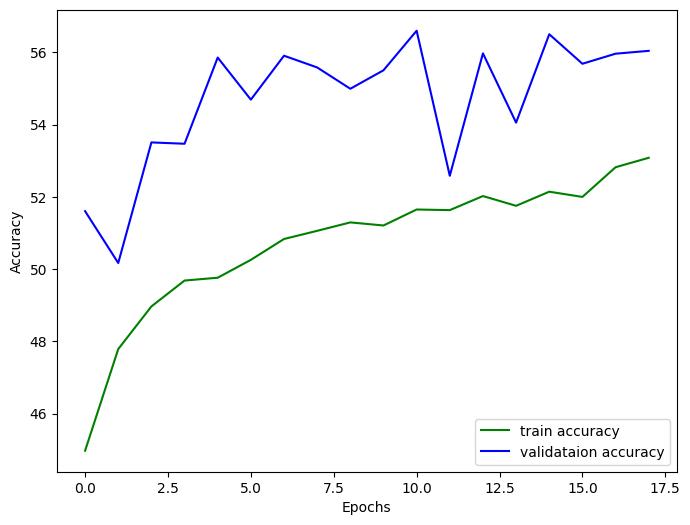

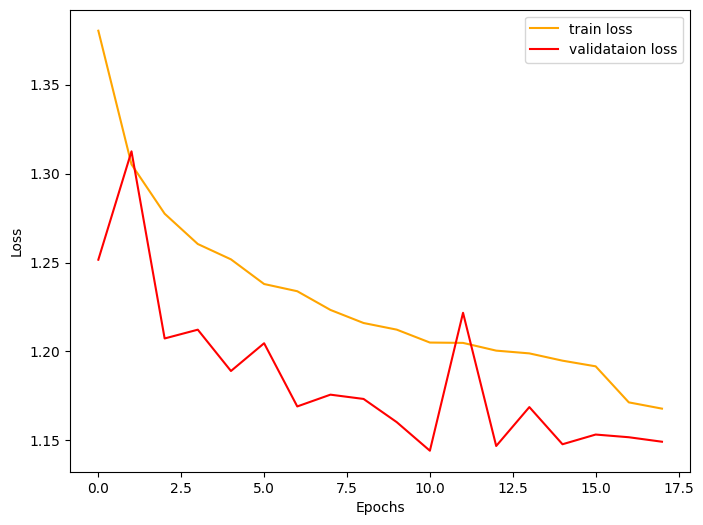

In [32]:
# save the loss and accuracy plots
save_plots(train_acc, valid_acc, train_loss, valid_loss)

**Test evaluation**

  0%|          | 0/337 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
100%|██████████| 337/337 [06:49<00:00,  1.22s/it]





Precision: 0.5358958043928364
Recall: 0.560419664825217
F1-score: 0.5314243251503201
Classification Report:
              precision    recall  f1-score   support

        High       0.28      0.32      0.30      1609
         Low       0.30      0.10      0.15      2599
    Moderate       0.19      0.27      0.22      1772
Non-burnable       0.71      0.85      0.77      5091
   Very_High       0.35      0.06      0.11      1438
    Very_Low       0.63      0.72      0.67      8448
       Water       0.90      0.65      0.75       584

    accuracy                           0.56     21541
   macro avg       0.48      0.42      0.42     21541
weighted avg       0.54      0.56      0.53     21541

\Confusion Matrix


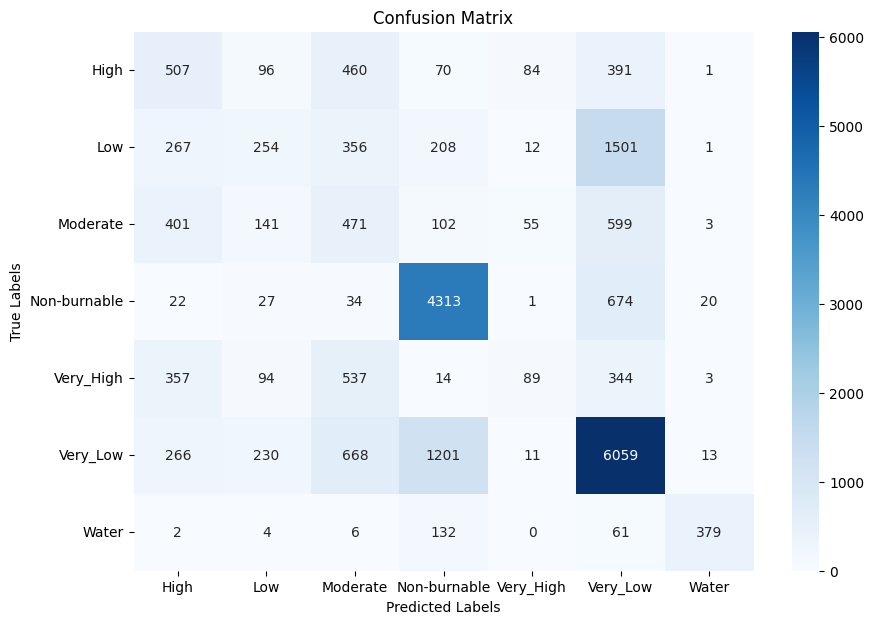

In [33]:
save_confusion_matrix(custom_model, valid_loader, label_names)